In [24]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from typing import Dict, List, Optional  
from dotenv import load_dotenv

In [25]:
load_dotenv()
REDDIT_CONFIG = {
    'client_id': os.getenv('REDDIT_CLIENT_ID'),
    'client_secret': os.getenv('REDDIT_CLIENT_SECRET'),
    'user_agent': os.getenv('REDDIT_USER_AGENT'),
    'redirect_uri': os.getenv('REDDIT_REDIRECT_URI')
}
if all(REDDIT_CONFIG.values()):
    print("Environment variables loaded successfully!")
else:
    print("Missing environment variables. Please check your .env file!")
    missing = [k for k, v in REDDIT_CONFIG.items() if not v]
    print(f"Missing values for: {missing}")

Environment variables loaded successfully!


In [39]:
class RedditAPI:
    def __init__(self):
        self.client_id = REDDIT_CONFIG['client_id']
        self.client_secret = REDDIT_CONFIG['client_secret']
        self.user_agent = REDDIT_CONFIG['user_agent']
        self.auth = requests.auth.HTTPBasicAuth(self.client_id, self.client_secret)
        self.token = None
        self.token_expiry = 0

    def _get_token(self) -> None:
        """Get OAuth token from Reddit"""
        try:
            data = {
                'grant_type': 'client_credentials'
            }
            headers = {'User-Agent': self.user_agent}
            
            print("Attempting to authenticate...")
            response = requests.post(
                'https://www.reddit.com/api/v1/access_token',
                auth=self.auth,
                data=data,
                headers=headers
            )
            
            if response.status_code == 200:
                self.token = response.json()['access_token']
                self.token_expiry = time.time() + 3600  # Token expires in 1 hour
                print("Authentication successful!")
            else:
                print(f"Authentication failed with status code: {response.status_code}")
                print(f"Response: {response.text}")
                response.raise_for_status()
                
        except Exception as e:
            print(f"Error during authentication: {str(e)}")
            raise

    def _ensure_valid_token(self) -> None:
        if not self.token or time.time() > self.token_expiry:
            self._get_token()

    def get_subreddit_posts(self, subreddit: str, limit: int = 25) -> List[Dict]:
        """Get posts from a subreddit"""
        self._ensure_valid_token()
        
        headers = {
            'User-Agent': self.user_agent,
            'Authorization': f'Bearer {self.token}'
        }
        
        params = {
            'limit': min(limit, 100)
        }
        
        response = requests.get(
            f'https://oauth.reddit.com/r/{subreddit}/hot',
            headers=headers,
            params=params
        )
        
        if response.status_code == 200:
            return [post['data'] for post in response.json()['data']['children']]
        else:
            print(f"Error fetching posts: {response.status_code}")
            print(f"Response: {response.text}")
            response.raise_for_status()
        def search_subreddits(self, query: str, min_subscribers: int = 10000, min_active_users: int = 100) -> List[Dict]:
            """Search for subreddits based on topic"""
            self._ensure_valid_token()
            
            print(f"\nDEBUG: Starting search for query: {query}")
            
            headers = {
                'User-Agent': self.user_agent,
                'Authorization': f'Bearer {self.token}'
            }
            
            params = {
                'q': query,
                'limit': 100,
                'sort': 'relevance',
                'include_over_18': False
            }
            
            print("\nDEBUG: Making request with:")
            print(f"Headers: {headers}")
            print(f"Params: {params}")
            
            try:
                response = requests.get(
                    'https://oauth.reddit.com/subreddits/search',
                    headers=headers,
                    params=params
                )
                
                print(f"\nDEBUG: Response Status Code: {response.status_code}")
                
                if response.status_code == 200:
                    data = response.json()
                    print("\nDEBUG: Full API Response:")
                    print(f"Response Type: {type(data)}")
                    print(f"Response Keys: {data.keys() if isinstance(data, dict) else 'Not a dictionary'}")
                    
                    if 'data' in data and 'children' in data['data']:
                        subreddits = []
                        print(f"\nDEBUG: Found {len(data['data']['children'])} subreddits")
                        
                        for i, subreddit in enumerate(data['data']['children']):
                            print(f"\nDEBUG: Processing subreddit {i + 1}")
                            if 'data' in subreddit:
                                sub_data = subreddit['data']
                                
                                # Get values with defaults for None
                                name = sub_data.get('display_name', '')
                                subscribers = sub_data.get('subscribers', 0) or 0  # Convert None to 0
                                active_users = sub_data.get('active_user_count', 0) or 0  # Convert None to 0
                                
                                print(f"Subreddit name: {name}")
                                print(f"Subscribers: {subscribers}")
                                print(f"Active users: {active_users}")
                                
                                # Only check subscribers as primary filter
                                if subscribers >= min_subscribers:
                                    clean_sub = {
                                        'name': name,
                                        'title': sub_data.get('title', ''),
                                        'description': sub_data.get('public_description', ''),
                                        'subscribers': subscribers,
                                        'active_users': active_users,
                                        'url': f"https://reddit.com{sub_data.get('url', '')}"
                                    }
                                    subreddits.append(clean_sub)
                                    print("Added to results list")
                                else:
                                    print("Filtered out due to subscriber count")
                        
                        # Sort by subscriber count
                        sorted_subreddits = sorted(subreddits, key=lambda x: x['subscribers'], reverse=True)
                        print(f"\nDEBUG: Final Results Count: {len(sorted_subreddits)}")
                        return sorted_subreddits
                    else:
                        print("DEBUG: No valid data structure found in response")
                        return []
                else:
                    print(f"DEBUG: Error Response Content: {response.text}")
                    response.raise_for_status()
                    
            except Exception as e:
                print(f"DEBUG: Exception occurred: {str(e)}")
                print(f"DEBUG: Exception type: {type(e)}")
                raise             


In [40]:
reddit = RedditAPI()

In [41]:
posts = reddit.get_subreddit_posts('tech', limit=5)
posts_df = pd.DataFrame(posts)

Attempting to authenticate...
Authentication successful!


In [42]:
posts = reddit.search_subreddits('tech', limit=5)

AttributeError: 'RedditAPI' object has no attribute 'search_subreddits'

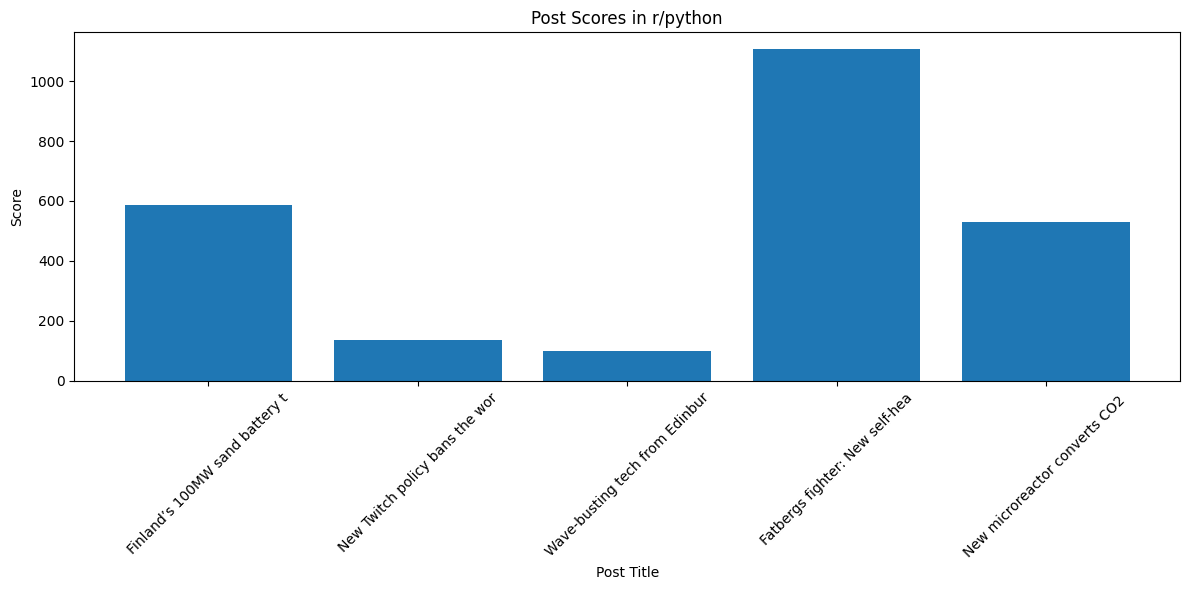

In [29]:
plt.figure(figsize=(12, 6))
plt.bar(posts_df['title'].str[:30], posts_df['score'])
plt.xticks(rotation=45)
plt.title('Post Scores in r/python')
plt.xlabel('Post Title')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [35]:
def main():
    reddit = RedditAPI()
    
    TECH_TOPICS = [
        "programming",
        "software",
        "technology",
        "webdev",
        "coding"
    ]
    
    try:
        print("Searching tech subreddits...")
        for topic in TECH_TOPICS:
            print(f"\nSearching for '{topic}':")
            subreddits = reddit.search_subreddits(topic)
            
            print(f"Found {len(subreddits)} relevant subreddits:")
            for i, sub in enumerate(subreddits[:5], 1):  # Show top 5 for each topic
                print(f"\n{i}. r/{sub['name']}")
                print(f"   Subscribers: {sub['subscribers']:,}")
                print(f"   Active Users: {sub['active_users']:,}")
                print(f"   Description: {sub['description'][:100]}...")
                
    except Exception as e:
        print(f"An error occurred: {str(e)}")



In [36]:
if __name__ == "__main__":
    main()

Searching tech subreddits...

Searching for 'programming':
An error occurred: 'RedditAPI' object has no attribute 'search_subreddits'
